In [1]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data as Data
import matplotlib.pyplot as plt
import torch
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
batch_size = 200
learning_rate = 0.01
epochs = 5

train_data = datasets.MNIST('../../../../Other/datasets/PyTorch',
                   train=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_data = datasets.MNIST('../../../../Other/datasets/PyTorch',
                           train=False,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))


# 手写数字训练数据集
train_loader = Data.DataLoader(dataset=train_data,
                               batch_size=batch_size,
                               shuffle=True)

# 手写数字测试数据集
test_loader = Data.DataLoader(dataset=test_data,
                              batch_size=batch_size,
                              shuffle=True)

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.featrues = nn.Sequential( # 内部实现了forward函数;各模块顺序执行
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10), # 10分类问题
        )

    def forward(self, x):
        x = self.featrues(x)
        x = x.reshape(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [4]:
criteon = nn.CrossEntropyLoss() # 定义损失函数为交叉熵
net = LeNet()

# 多参数组的SGD优化器
optimizer = optim.SGD([dict(params=net.featrues.parameters(), momentum=0.9),
                       dict(params=net.classifier.parameters(),
                            momentum=0.95, # 动量参数\alpha;默认momentum=0
                            nesterov=True)], # 是否启用Nesterov动量
                      lr=learning_rate) # 学习率

train_acc_lst = list() # 训练数据精度
test_acc_lst = list() # 测试数据精度
train_loss_lst = list() # 训练数据损失

for epoch in range(0, epochs):
    for batch_index, (data, target) in enumerate(train_loader):
        cnn = net(data)

        loss = criteon(cnn, target)
        optimizer.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        optimizer.step() # 进行一次梯度更新

        if (batch_index+1) % 10 == 0:
            train_loss_lst.append(loss)
            valid_train_sampler = Data.sampler.SubsetRandomSampler(torch.randperm(len(train_data))[:500])
            valid_train_loader = Data.DataLoader(dataset=train_data, sampler=valid_train_sampler) # 随机选取500条数据进行验证
            valid_test_sampler = Data.sampler.SubsetRandomSampler(torch.randperm(len(test_data))[:500])
            valid_test_loader = Data.DataLoader(dataset=test_data, sampler=valid_test_sampler)
            train_t_n = 0
            test_t_n = 0
            for i, j in valid_train_loader:
                predict = torch.argmax(net(i), dim=1)
                if (predict[0].item() - j) == 0:
                    train_t_n = train_t_n + 1
            for m, n in valid_test_loader:
                predict = torch.argmax(net(m), dim=1)
                if (predict[0].item()) - n == 0:
                   test_t_n = test_t_n + 1

            train_acc = train_t_n / 500
            test_acc = test_t_n / 500
            train_acc_lst.append(train_acc)
            test_acc_lst.append(test_acc)

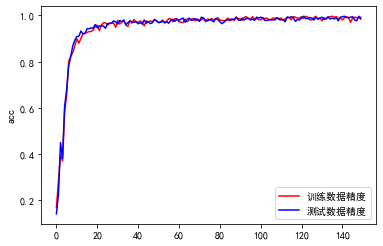

In [5]:
plt.plot(train_acc_lst, color='r', label='训练数据精度')
plt.plot(test_acc_lst, color='b', label='测试数据精度')
plt.legend()
plt.ylabel('acc')
plt.show()

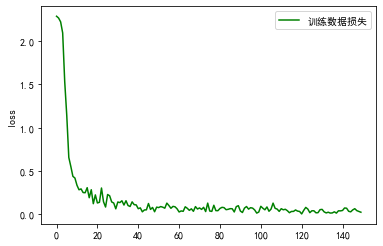

In [6]:
plt.plot(train_loss_lst, color='g', label='训练数据损失')
plt.legend()
plt.ylabel('loss')
plt.show()